In [ ]:
"""
El objetivos es realizar el preeliminar para poder predecir la probabilidad de un usuario compre basado en su comportamiento y transacciones pasadas.

Cliente objetivo:
- Sellers premium
- Marcas interesadas en targeting
- Equipos internos de marketing

Output:
- Propensity score (0-1)
- Ranking de usuarios
- Insights sobre features más importantes
"""


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report

# Para visualización de importancia
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Path base
DATA_RAW = Path("../data/raw")


In [ ]:


# Normalizar t# Cargar datos
users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")
products = pd.read_csv(DATA_RAW / "products.csv")imestamp de eventos
events["event_timestamp"] = pd.to_datetime(events["timestamp"])


# Número total de eventos por usuario
num_events = events.groupby("user_id").size()

# Promedio de tiempo entre eventos por usuario
avg_time_between_events = (
    events.sort_values(["user_id", "event_timestamp"])
    .groupby("user_id")["event_timestamp"]
    .diff()
    .dt.total_seconds()
    .groupby(events["user_id"])
    .mean()
)


# Contar eventos por tipo para cada usuario
event_counts = events.pivot_table(
    index="user_id",
    columns="event_type",
    values="event_id",
    aggfunc="count",
    fill_value=0
).reset_index()

# Crear dataframe base
X = pd.DataFrame({
    "user_id": num_events.index,
    "num_events": num_events.values,
    "avg_time_between_events": avg_time_between_events.values
})

# Merge seguro con event_counts
X = pd.merge(X, event_counts, on="user_id", how="left").fillna(0)



last_event = events.groupby("user_id")["event_timestamp"].max()
X["days_since_last_event"] = (pd.Timestamp.today() - last_event).dt.days
X["days_since_last_event"] = X["days_since_last_event"].fillna(X["days_since_last_event"].max())


buyers = set(transactions["user_id"])
X["is_buyer"] = X["user_id"].isin(buyers).astype(int)

# Poner user_id como índice
X = X.set_index("user_id")
X.head()

,num_events,avg_time_between_events,add_to_cart,product_view,purchase,days_since_last_event,is_buyer
user_id,,,,,,,
1,8,2.894794e+06,0,6,2,737.0,1
2,11,2.479506e+06,2,9,0,425.0,0
3,14,2.035925e+06,1,12,1,425.0,1
4,6,5.923344e+06,2,4,0,423.0,1
5,1,0.000000e+00,0,1,0,382.0,0


In [30]:

# FEATURES CRUZADAS TEST

import pandas as pd
import numpy as np


users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")
products = pd.read_csv(DATA_RAW / "products.csv")

# Normalizar timestamps
events["event_timestamp"] = pd.to_datetime(events["timestamp"])


# Número total de eventos
num_events = events.groupby("user_id").size()

# Promedio de tiempo entre eventos
avg_time_between_events = (
    events.sort_values(["user_id", "event_timestamp"])
    .groupby("user_id")["event_timestamp"]
    .diff()
    .dt.total_seconds()
    .groupby(events["user_id"])
    .mean()
)

# Último evento (recencia)
last_event = events.groupby("user_id")["event_timestamp"].max()
days_since_last_event = (pd.Timestamp.today() - last_event).dt.days

event_counts = events.pivot_table(
    index="user_id",
    columns="event_type",
    values="event_id",
    aggfunc="count",
    fill_value=0
)


# Traer precio del producto de cada evento
events_prod = events.merge(products[["product_id", "price"]], on="product_id", how="left")

# Precio promedio de los productos vistos por usuario
avg_price_viewed = events_prod.groupby("user_id")["price"].mean().fillna(0)

# Número de productos únicos vistos
unique_products_viewed = events_prod.groupby("user_id")["product_id"].nunique()

# Solo datos históricos hasta ahora
transactions_agg = transactions.groupby("user_id").agg(
    total_items_bought=("quantity", "sum"),
    unique_products_bought=("product_id", "nunique")
)

# Si users tiene columnas como 'age', 'region', etc.
demographics = users.set_index("user_id")

X = pd.DataFrame({
    "num_events": num_events,
    "avg_time_between_events": avg_time_between_events,
    "days_since_last_event": days_since_last_event,
    "avg_price_viewed": avg_price_viewed,
    "unique_products_viewed": unique_products_viewed
}).fillna(0)

# Merge con conteo por tipo de evento
X = X.join(event_counts, how="left").fillna(0)

# Merge con historial de compras previas
X = X.join(transactions_agg, how="left").fillna(0)

# Merge con demografía
X = X.join(demographics, how="left").fillna(0)

buyers = set(transactions["user_id"])
X["is_buyer"] = X.index.isin(buyers).astype(int)
X.head()


,num_events,avg_time_between_events,days_since_last_event,avg_price_viewed,unique_products_viewed,add_to_cart,product_view,purchase,total_items_bought,unique_products_bought,registration_date,country,segment,is_buyer
user_id,,,,,,,,,,,,,,
1,8,2.894794e+06,425,243.512500,8,0,6,2,6.0,2.0,2023-11-02,US,returning,1
2,11,2.479506e+06,425,275.865455,11,2,9,0,0.0,0.0,2022-10-14,ES,vip,0
3,14,2.035925e+06,424,304.361429,14,1,12,1,5.0,2.0,2023-09-21,US,returning,1
4,6,5.923344e+06,383,292.518333,6,2,4,0,5.0,2.0,2022-05-31,US,vip,1
5,1,0.000000e+00,722,310.880000,1,0,1,0,0.0,0.0,2023-09-29,AR,returning,0


In [ ]:
# Copiar dataframe
X_model = X.copy()

# Fecha de registro -> número de días desde hoy
X_model['registration_date'] = pd.to_datetime(X_model['registration_date'])
X_model['days_since_registration'] = (pd.Timestamp.today() - X_model['registration_date']).dt.days
X_model = X_model.drop(columns=['registration_date'])  # borrar columna original

# Convertir categóricas a dummies
X_model = pd.get_dummies(X_model, columns=['country','segment'], drop_first=True)

# Separar target
y = X_model['is_buyer']
X_model = X_model.drop(columns=['is_buyer'])



In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

y_pred_proba = rf_model.predict_proba(X_test)[:,1]
y_pred = rf_model.predict(X_test)

print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred))


ROC-AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       919
           1       1.00      1.00      1.00      9081

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [41]:
y.value_counts(normalize=True)


is_buyer
1    0.908073
0    0.091927
Name: proportion, dtype: float64

✅ Modelo entrenado correctamente.
ROC-AUC: 0.5068

              precision    recall  f1-score   support

           0       0.10      0.30      0.14       919
           1       0.91      0.71      0.80      9081

    accuracy                           0.67     10000
   macro avg       0.50      0.51      0.47     10000
weighted avg       0.83      0.67      0.74     10000

Top 10 usuarios por propensión:


,num_events,avg_time_between_events,days_since_last_event,avg_price_viewed,unique_products_viewed,country_CO,country_ES,country_MX,country_US,segment_returning,segment_vip,propensity_score
user_id,,,,,,,,,,,,
8251,1,0.000000e+00,395,13.950000,1,True,False,False,False,False,False,0.763781
43762,23,1.339238e+06,387,230.906087,23,False,False,True,False,False,False,0.729101
30546,22,1.286669e+06,422,226.585455,22,False,False,True,False,False,True,0.727106
38186,22,1.336480e+06,400,229.295455,22,False,False,True,False,False,True,0.719649
46636,1,0.000000e+00,422,15.910000,1,False,False,False,False,False,False,0.711721
23700,22,1.370957e+06,395,224.692727,22,False,False,False,False,False,True,0.709631
2380,22,1.333731e+06,413,262.210000,22,False,True,False,False,False,False,0.703986
8192,22,1.456489e+06,383,270.378182,22,False,False,False,False,True,False,0.693032
26343,1,0.000000e+00,484,92.020000,1,False,False,False,True,False,False,0.684563


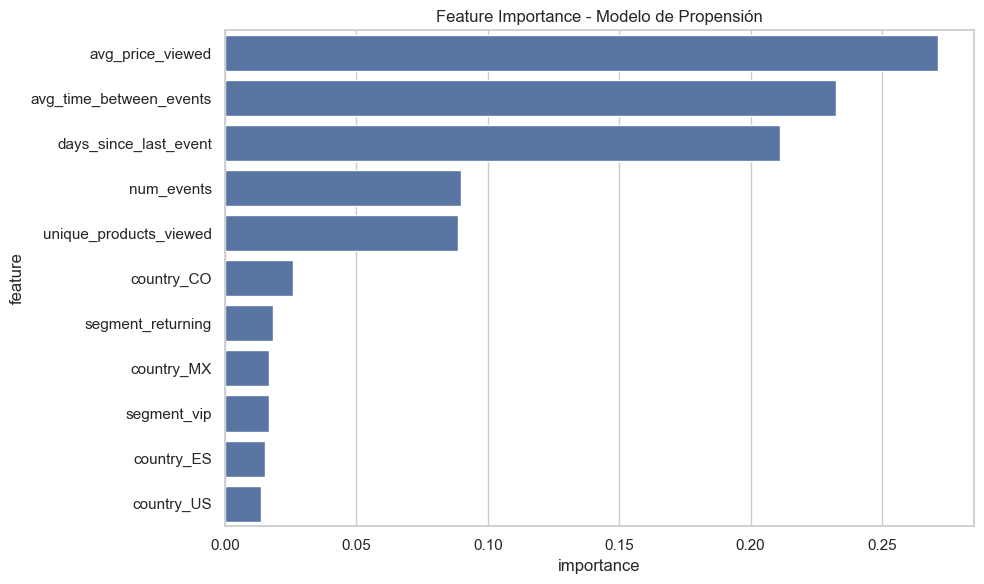

In [ ]:
# Codigo completo para el modelod de propension
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# features válidas (solo info previa a la compra)

X_model = X.copy()

# Convertir fecha de registro a número de días desde hoy
X_model['registration_date'] = pd.to_datetime(X_model['registration_date'])
X_model['days_since_registration'] = (pd.Timestamp.today() - X_model['registration_date']).dt.days
X_model = X_model.drop(columns=['registration_date'])

# Features previas a compra
valid_features = [
    'num_events',
    'avg_time_between_events',
    'days_since_last_event',
    'avg_price_viewed',
    'unique_products_viewed',
    'country',
    'segment'
]

X_model = X_model[valid_features + ['is_buyer']]
y = X_model['is_buyer']
X_model = X_model.drop(columns=['is_buyer'])
X_model_enc = pd.get_dummies(X_model, columns=['country','segment'], drop_first=True)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_model_enc, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar Random Forest con balance de clases

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
print("✅ Modelo entrenado correctamente.")


# Predicciones

y_pred_proba = rf_model.predict_proba(X_test)[:,1]
y_pred = rf_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}\n")
print(classification_report(y_test, y_pred))

# Propensity Score
X_test = X_test.copy()
X_test['propensity_score'] = y_pred_proba

print("Top 10 usuarios por propensión:")
display(X_test.sort_values('propensity_score', ascending=False).head(10))
# Importancia de variables

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance - Modelo de Propensión')
plt.tight_layout()
plt.show()


In [43]:
import joblib

joblib.dump(rf_model, "../src/models/propension/model.pkl")


['../src/models/propension/model.pkl']